In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

In [3]:

# 1. Load Dataset
df = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')
df = df.drop_duplicates()

In [4]:
# 2. Feature Engineering
df['car_age'] = 2020 - df['year']
df['mileage_per_year'] = df['km_driven'] / df['car_age'].replace(0,1)

In [5]:
# Extract brand and model
df['brand'] = df['name'].str.split().str[0]
df['model'] = df['name'].str.split().str[1]

In [6]:
# Interaction features
df['age_x_km'] = df['car_age'] * df['km_driven']

In [7]:
# Outlier Removal
price_cap = df['selling_price'].quantile(0.99)
km_cap = df['km_driven'].quantile(0.99)
df = df[(df['selling_price'] <= price_cap) & (df['km_driven'] <= km_cap)]
df.reset_index(drop=True, inplace=True)

In [8]:
# Select Features and Target
X = df[['car_age','km_driven','mileage_per_year','fuel','seller_type','transmission','owner','brand','model','age_x_km']]
y = df['selling_price']  # Use raw price for tree-based models

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# One-Hot Encode Categoricals
categorical_cols = ['fuel','seller_type','transmission','owner','brand','model']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

In [11]:
# Initialize Models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(
    n_estimators=500, max_depth=25, min_samples_split=5, min_samples_leaf=3, random_state=42, n_jobs=-1
)
xgb_model = XGBRegressor(
    n_estimators=1000, max_depth=10, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42
)


In [12]:
# 8. Create Pipelines
lr_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', lr_model)])
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', rf_model)])
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', xgb_model)])

In [13]:
# Train and Predict
# Linear Regression
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Random Forest
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# XGBoost
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

In [14]:
# Evaluation Function
def evaluate(y_true, y_pred, model_name):
    print(f"{model_name} Evaluation:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))
    print("-"*40)

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBoost")

Linear Regression Evaluation:
MAE: 194981.00287722284
RMSE: 315450.2613510443
R²: 0.29592534557342565
----------------------------------------
Random Forest Evaluation:
MAE: 113220.97202521785
RMSE: 213002.82606157064
R²: 0.6789832757788916
----------------------------------------
XGBoost Evaluation:
MAE: 93242.671875
RMSE: 173970.5479441851
R²: 0.7858548164367676
----------------------------------------


/tmp/ipython-input-3148081897.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='viridis')


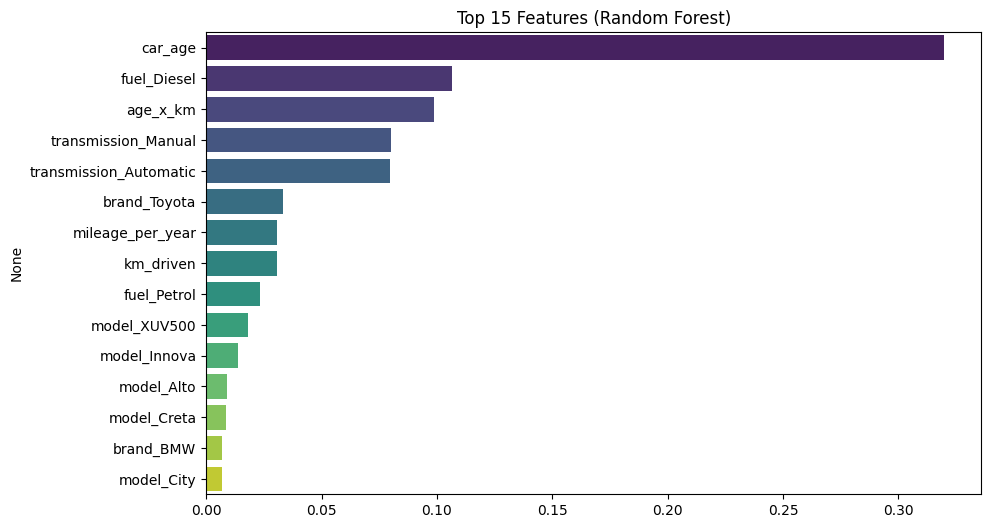

In [15]:
# Feature Importance (Random Forest)
rf_features = rf_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_features = np.concatenate([rf_features, X_train.drop(columns=categorical_cols).columns])
importances = pd.Series(rf_model.feature_importances_, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='viridis')
plt.title("Top 15 Features (Random Forest)")
plt.show()